# Naive bayes

# Loading data

In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'with', 'she', 'no', 'did', "hadn't", 'itself', 'ours', 'until', 'had', 'its', 'yourselves', "should've", 'now', "wasn't", 'other', 'from', "that'll", 'these', 'each', 'don', 'such', "hasn't", 'wouldn', "haven't", 'yourself', 'didn', 'all', 'then', "you're", 'as', 'do', 'if', 'whom', 'the', 'll', 'shouldn', 'have', 'again', 'm', 'after', 'weren', 'off', 'on', "isn't", 't', 'same', 'shan', 'once', 'through', 'under', "aren't", "shan't", 'hadn', 'hasn', 'or', 'to', 'so', 'how', 'was', 'while', "needn't", 'below', 'just', 'what', 'this', 'against', 'having', 'over', 'has', 'about', 'yours', 'between', 'wasn', 'by', 'needn', 'be', 'few', 'more', 'further', "don't", 'haven', 'ourselves', "mightn't", 'were', 'herself', "you'd", 'during', 'up', 'those', 'it', 'than', 'isn', 'they', 'where', 'will', 'been', 'down', 'them', 'very', 'because', 'being', 'but', "won't", 'and', 'theirs', 'too', 'ain', 'am', 'ma', 'o', 'an', 'my', 'd', 're', "you'll", 'before', 'who', 'i', 'own', 'at', 'doing', 'bo

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [09:07<00:00, 664.98it/s]


In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    

In [0]:
final.to_pickle("./amazon.pkl")

In [20]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

# [2] Sorting data based on time

In [165]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
data = data.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(364171, 12)
1    307061
0     57110
Name: Score, dtype: int64


# [3] Spliting into train and test based on time (70:30)

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)


# [4] Bag of Words (BoW)

In [167]:
#Bag of words
count_vect = CountVectorizer() 

X_train = count_vect.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

X_test = count_vect.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 59198)
Test Data Size:  (109252, 59198)


## [4.1] Bernoulli naive bayes

In [0]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='f1', n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 93.27%


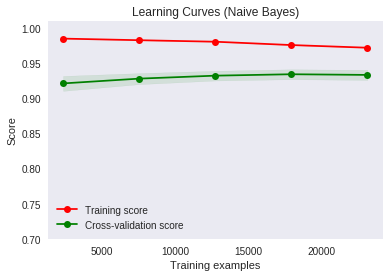

In [177]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,scoring='f1')

title = "Learning Curves (Naive Bayes)"

plot_learning_curve(gsv, title, X_train, y_train, ylim=(0.7, 1.01), cv=tscv, n_jobs=4)

gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Accuracy on test set: 88.343%
Precision on test set: 0.926
Recall on test set: 0.933
F1-Score on test set: 0.930


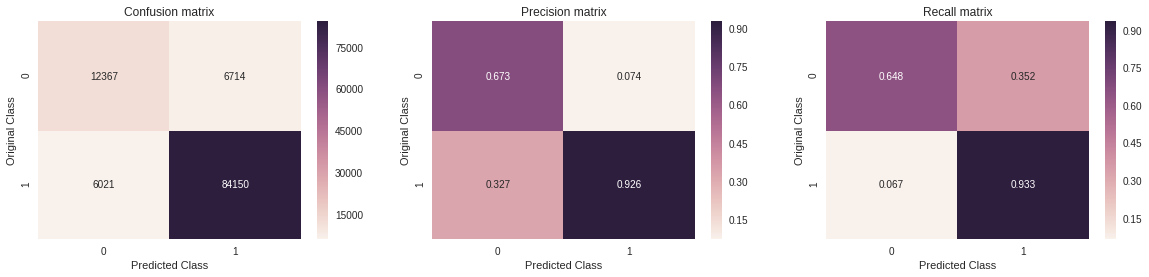

In [178]:
#Testing Accuracy on Test data
bnb = BernoulliNB(alpha=0.005)
bnb.fit(X_train,y_train)

y_pred = bnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.2] Multinomial Naive Bayes

Best Hyperparameter:  {'alpha': 0.005}
Best Accuracy: 92.80%


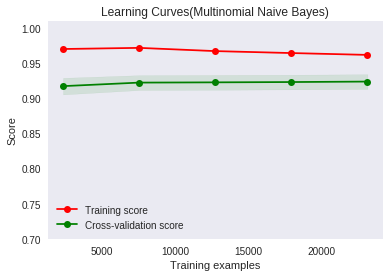

In [179]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
params = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
tscv = TimeSeriesSplit(n_splits = 10)
gscv = GridSearchCV(mnb, params, cv = tscv, scoring='f1')

title = "Learning Curves(Multinomial Naive Bayes)"

plot_learning_curve(gscv, title, X_train, y_train, ylim=(0.7, 1.01), cv=tscv, n_jobs=4)

gscv.fit(X_train, y_train)

print("Best Hyperparameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Accuracy on test set: 85.816%
Precision on test set: 0.855
Recall on test set: 0.997
F1-Score on test set: 0.921


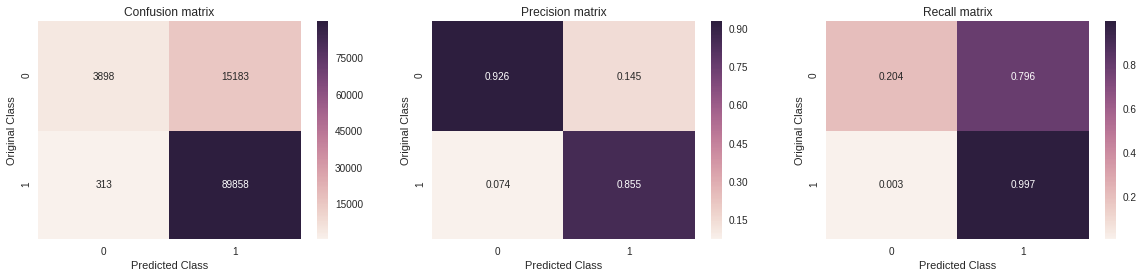

In [180]:
# Accuracy on testing data

mnb = MultinomialNB(alpha = 0.005)
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.3] Feature Importance

In [184]:
def features_importance(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("Negative\t\t\t\t\t\tPositive")
    print("-"*100)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
features_importance(count_vect,bnb)

Negative						Positive
----------------------------------------------------------------------------------------------------
-17.5855	aaaaaaarrrrrggghhh				-1.1898	like           
-17.5855	aaaaaahhhhhyaaaaaa				-1.2078	tast           
-17.5855	aachen         				-1.2728	love           
-17.5855	aarrgh         				-1.2770	good           
-17.5855	aauc           				-1.2940	great          
-17.5855	abalon         				-1.4290	flavor         
-17.5855	abbazabba      				-1.4724	one            
-17.5855	abiet          				-1.4907	use            
-17.5855	abolitionist   				-1.5344	tri            
-17.5855	abort          				-1.5642	product        
-17.5855	abottl         				-1.6464	make           
-17.5855	abrevi         				-1.6961	get            
-17.5855	abrotanum      				-1.9062	buy            
-17.5855	absolutelt     				-1.9097	time           
-17.5855	absoprt        				-1.9481	amazon         
-17.5855	absurt         				-1.9581	would          
-17.5855	abswer         				-1.9585	be

# [5] TF-IDF

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [186]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=10) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2000)
Test Data Size:  (109252, 2000)


## [5.1] Bernoulli naive bayes

Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 93.43%


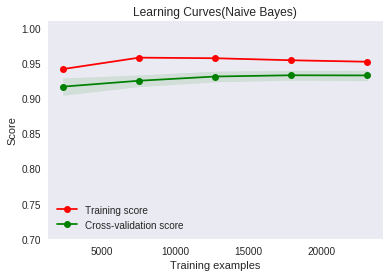

In [187]:
bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,scoring='f1')

title = "Learning Curves(Naive Bayes)"

plot_learning_curve(gsv, title, X_train, y_train, ylim=(0.7, 1.01), cv=tscv, n_jobs=4)

gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Accuracy on test set: 88.204%
Precision on test set: 0.937
Recall on test set: 0.919
F1-Score on test set: 0.928


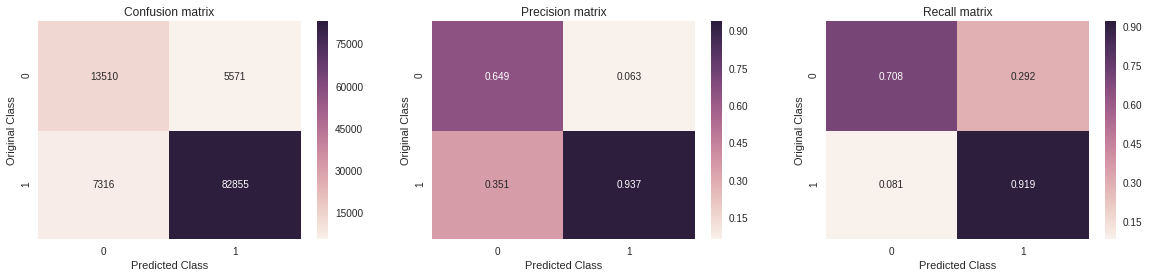

In [189]:
#Testing Accuracy on Test data

bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.2] Multinomial naive bayes

Best Hyperparameter:  {'alpha': 0.001}
Best Accuracy: 93.04%


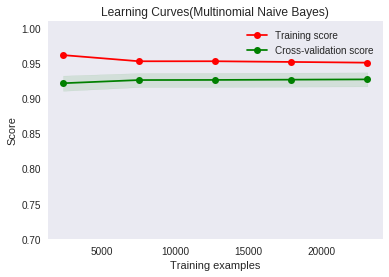

In [190]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
params = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
tscv = TimeSeriesSplit(n_splits = 10)
gscv = GridSearchCV(mnb, params, cv = tscv, scoring='f1')

title = "Learning Curves(Multinomial Naive Bayes)"

plot_learning_curve(gscv, title, X_train, y_train, ylim=(0.7, 1.01), cv=tscv, n_jobs=4)

gscv.fit(X_train, y_train)

print("Best Hyperparameter: ",gscv.best_params_)
print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

Accuracy on test set: 86.347%
Precision on test set: 0.860
Recall on test set: 0.996
F1-Score on test set: 0.923


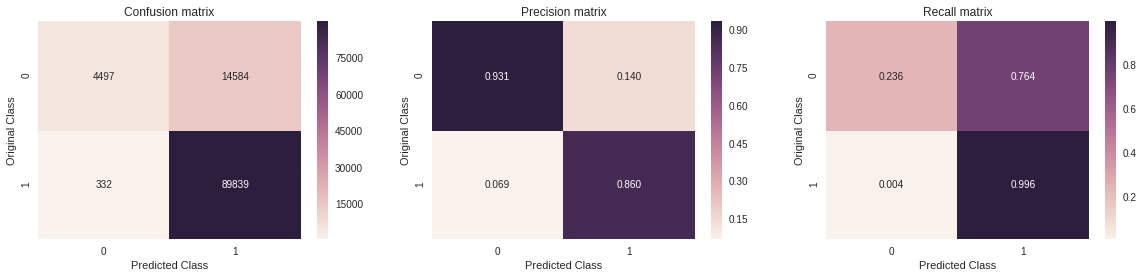

In [191]:
#Testing Accuracy on Test data

mnb = MultinomialNB(alpha=0.001)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.3] Feature Importance

In [192]:
def features_importance(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("Negative\t\t\t\t\tPositive")
    print("-"*100)
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
features_importance(tfidf,bnb)

Negative					Positive
----------------------------------------------------------------------------------------------------
-6.9938	wast money     				-1.1898	like           
-6.9544	wont buy       				-1.2078	tast           
-6.8023	trash          				-1.2728	love           
-6.7459	refund         				-1.2770	good           
-6.7112	never buy      				-1.2940	great          
-6.5900	tasteless      				-1.4290	flavor         
-6.4820	garbag         				-1.4724	one            
-6.4321	vomit          				-1.4907	use            
-6.4321	worst          				-1.5344	tri            
-6.4264	mate           				-1.5642	product        
-6.4235	buyer          				-1.6464	make           
-6.4235	disgust        				-1.6961	get            
-6.3983	threw          				-1.9062	buy            
-6.3629	rooibo         				-1.9097	time           
-6.3602	oreo           				-1.9481	amazon         
-6.3576	fli            				-1.9581	would          
-6.3549	tazo           				-1.9585	best           
-6.3313	un

# [6] Performance Table

In [194]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["FEATURIZATION", "MODEL", "ALPHA", "F1-SCORE"]

x.add_row(["BOW", "Bernoulli", 0.005,0.930])
x.add_row(["", "Multinomial", 0.001, 0.921])
x.add_row(["TF_IDF", "Bernoulli", 0.005, 0.928])
x.add_row(["", "Multinomial", 0.001, 0.923])

print(x)

+---------------+-------------+-------+----------+
| FEATURIZATION |    MODEL    | ALPHA | F1-SCORE |
+---------------+-------------+-------+----------+
|      BOW      |  Bernoulli  | 0.005 |   0.93   |
|               | Multinomial | 0.001 |  0.921   |
|     TF_IDF    |  Bernoulli  | 0.005 |  0.928   |
|               | Multinomial | 0.001 |  0.923   |
+---------------+-------------+-------+----------+


# Obseration

   1. Naive Bayes is much faster algorithm than KNN
   2. The performance of bernoulli naive bayes is way much more better than multinomial naive bayes.
   3. Best F1 score is acheived by BOW featurization which is 0.930